In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
bigp = [
    'BNP', 'Jamaat', 'JaPa', 'Islami Andolan Bangladesh',
    'GOP (Nuru)', 'Bangladesh Khelafat Majlish', 'Khelafat Majlish',
    'CPB', 'AB Party', 'NCP', 'Independent'
]
mainp = ['BNP', 'Jamaat', 'JaPa', 'NCP', 'Independent']

In [3]:
bdmap = gpd.read_file('map/seats.shp')
bdmap.head()

,seat_no,seat,district,division,region,shape_len,shape_area,geometry
0,1,Panchagarh-1,Panchagarh,Rangpur,Urban,2.787812,0.061199,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
1,2,Panchagarh-2,Panchagarh,Rangpur,Rural,1.411258,0.064286,"POLYGON ((88.76158 26.30059, 88.76176 26.29971..."
2,3,Thakurgaon-1,Thakurgaon,Rangpur,Urban,1.255212,0.058832,"POLYGON ((88.55589 26.17948, 88.55684 26.17788..."
3,4,Thakurgaon-2,Thakurgaon,Rangpur,Rural,1.858839,0.045806,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,..."
4,5,Thakurgaon-3,Thakurgaon,Rangpur,Rural,1.810654,0.059069,"POLYGON ((88.25475 26.03583, 88.25828 26.03391..."


In [4]:
dfa = pd.read_csv('data/affidavit.csv')
dfa = dfa[['filename', 'name_bn', 'zillaID', 'constituencyID', 'income', 'tax', 'wealth', 'party', 'final', 'symbol']]
dfa.head()

,filename,name_bn,zillaID,constituencyID,income,tax,wealth,party,final,symbol
0,"1,109,মশিউর রহমান.txt",মশিউর রহমান,1,109,NaN,NaN,NaN,Independent,False,NaN
1,"1,109,মোঃ অলি উল্লাহ.txt",মোঃ অলি উল্লাহ,1,109,800000.0,45000.0,NaN,Islami Andolan Bangladesh,True,হাতপাখা
2,"1,109,মোঃ জামাল হোসাইন.txt",মোঃ জামাল হোসাইন,1,109,5000.0,5000.0,713000.0,JP (Manju),True,বাইসাইকেল
3,"1,109,মোঃ জাহাঙ্গীর হোসাইন.txt",মোঃ জাহাঙ্গীর হোসাইন,1,109,471500.0,7150.0,3890900.0,Khelafat Majlish,True,দেওয়াল ঘড়ি
4,"1,109,মোঃ মুহিব্বুল্যাহ.txt",মোঃ মুহিব্বুল্যাহ,1,109,NaN,NaN,NaN,Jamaat,False,NaN


In [5]:
dfa.shape

(2446, 10)

In [6]:
dfa = dfa[dfa.final]
dfa.shape

(1889, 10)

### net wealth distribution

In [7]:
# group data by seats and count median of net wealth
dfwmed = dfa[['constituencyID', 'wealth']].groupby('constituencyID').agg(w_med=('wealth', 'median')).reset_index()
dfwmed.head()

,constituencyID,w_med
0,1,NaN
1,2,NaN
2,3,2959659.5
3,4,4352780.0
4,5,1875000.0


In [8]:
dfwmed.shape

(279, 2)

Text(0, 0.5, 'wealth')

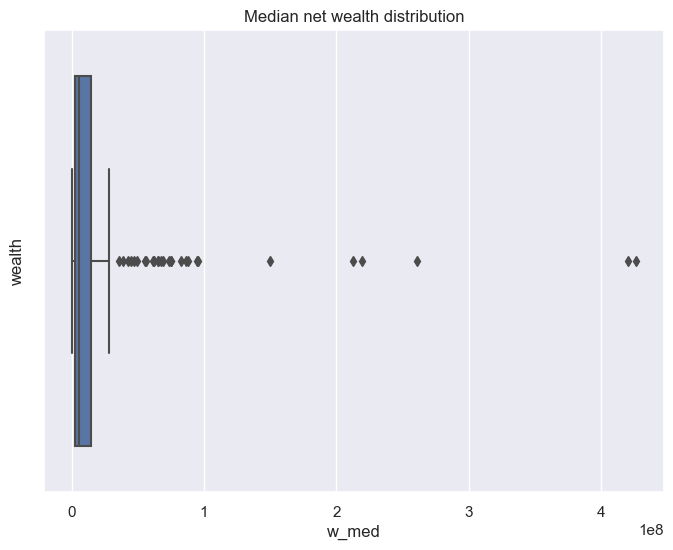

In [10]:
# plot distribution of median net wealth
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=dfwmed, x="w_med", ax=ax)
ax.set_title('Median net wealth distribution')
ax.set_ylabel('wealth')

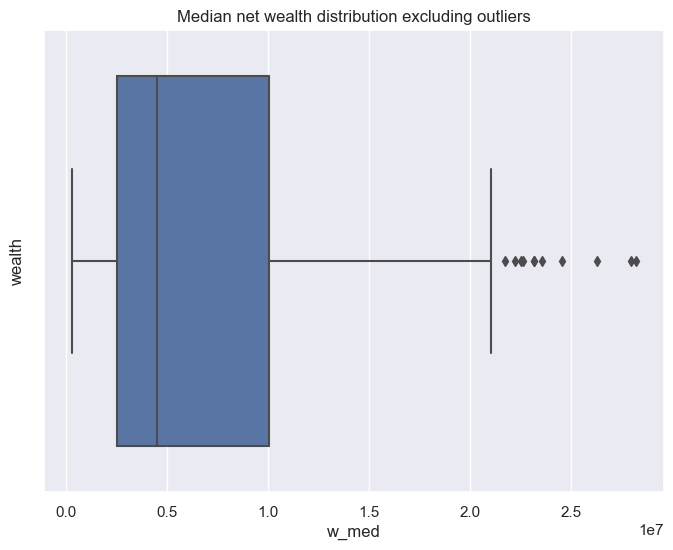

In [11]:
# plot distribution of wealth excluding outliers
Q1 = dfwmed['w_med'].quantile(0.25)
Q3 = dfwmed['w_med'].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - (1.5*IQR)
ub = Q3 + (1.5*IQR)
fig, ax = plt.subplots(figsize=(8, 6))
dfwmed_noout = dfwmed[(dfwmed.w_med > lb) & (dfwmed.w_med < ub)]
sns.boxplot(data=dfwmed_noout, x="w_med", ax=ax)
ax.set_title('Median net wealth distribution excluding outliers')
ax.set_ylabel('wealth')
fig.savefig('fig/affidavit_wealth_med_distn',bbox_inches='tight')

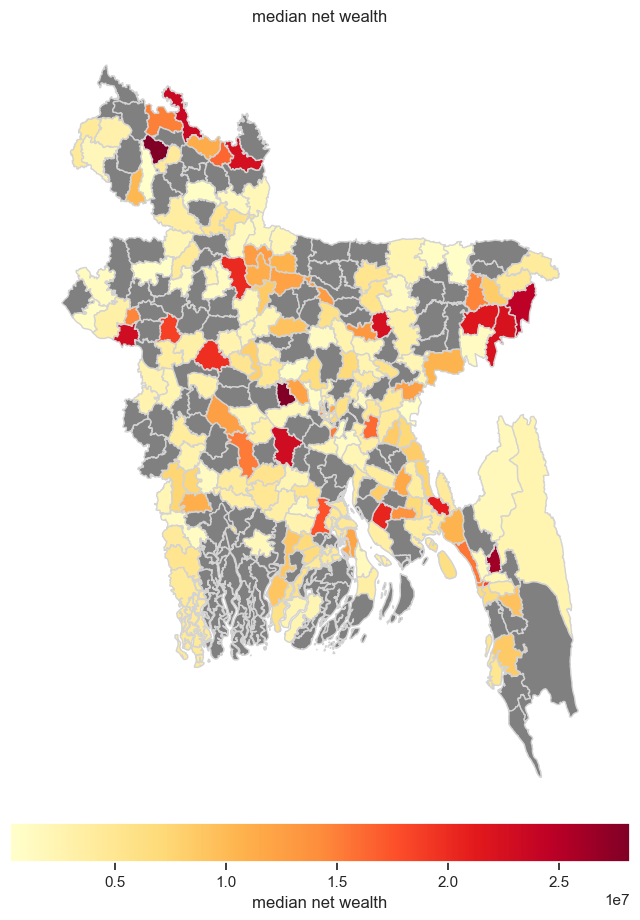

In [12]:
# plot map of median net wealth excluding outliers
mapwmed = pd.merge(bdmap, dfwmed_noout, how='left', left_on='seat_no', right_on='constituencyID')

fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

mapwmed.plot(
    column='w_med', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True,
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "missing data",
    }, 
    legend_kwds={
    'label': 'median net wealth',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("median net wealth")
fig.savefig('fig/affidavit_wealth_med',bbox_inches='tight')

In [13]:
# median net wealth by region
pd.merge(
    bdmap[['seat_no', 'region']], dfa[['constituencyID', 'wealth']], 
    how='right', left_on='seat_no', right_on='constituencyID'
).groupby(
    'region'
).agg(
    count=('seat_no', 'count'), w_med=('wealth', 'median')
).reset_index()

,region,count,w_med
0,Rural,1284,4366390.0
1,Urban,605,5120890.0


In [14]:
dfwmed_div = mapwmed.groupby('division')['w_med'].mean().reset_index().sort_values(by='w_med', ascending=False)
dfwmed_div.head()

,division,w_med
7,Sylhet,9.699042e+06
6,Rangpur,8.482352e+06
1,Chittagong,7.926134e+06
2,Dhaka,6.815236e+06
4,Mymensingh,6.718583e+06


In [15]:
dfwmed.to_csv('dataout/affidavit_wealth_med_by_division.csv', index=False)

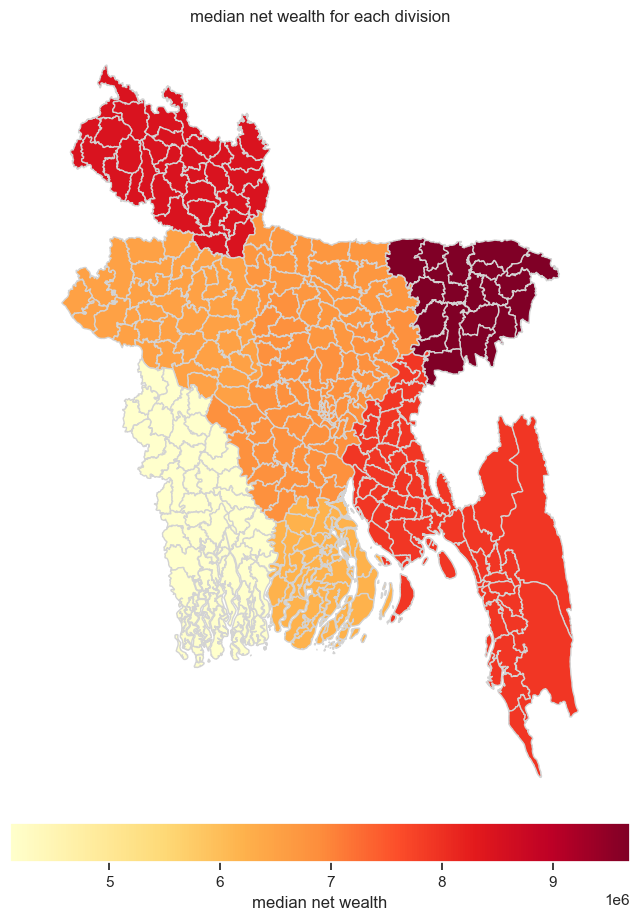

In [16]:
# plot map of median net wealth of divisions
mapwmed_div = pd.merge(bdmap, dfwmed_div, how='left', on='division')

fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

mapwmed_div.plot(
    column='w_med', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True,
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "missing data",
    }, 
    legend_kwds={
    'label': 'median net wealth',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("median net wealth for each division")
fig.savefig('fig/affidavit_wealth_med_by_division',bbox_inches='tight')

### party with wealthiest candidate in each district

In [17]:
dfamainp = dfa[dfa.party.isin(mainp)]
idxwmax = dfamainp[['zillaID', 'party', 'wealth']].groupby('zillaID')['wealth'].idxmax().dropna()
dfpwmax = dfamainp.loc[idxwmax]
dfpwmax.head()

,filename,name_bn,zillaID,constituencyID,income,tax,wealth,party,final,symbol
469,"2,120,সরদার সরফুদ্দিন আহমেদ.txt",সরদার সরফুদ্দিন আহমেদ,2,120,NaN,0.0,10363773.0,BNP,True,ধানের শীষ
821,"3,116,মোহাম্মদ ফজলুল করিম.txt",মোহাম্মদ ফজলুল করিম,3,116,181532.0,175.0,1979915.0,Jamaat,True,দাঁড়িপাল্লা
1139,"4,125,রফিকুল ইসলাম জামাল.txt",রফিকুল ইসলাম জামাল,4,125,4971971.0,82680.0,46854516.0,BNP,True,ধানের শীষ
2091,"6,129,মোঃ মাশরেকুল আজম (রবি).txt",মোঃ মাশরেকুল আজম (রবি),6,129,875126.0,48769.0,12217051.0,JaPa,True,লাঙ্গল
2401,"8,291,আলহাজ্ব জসীম উদ্দীন আহমেদ.txt",আলহাজ্ব জসীম উদ্দীন আহমেদ,8,291,24245738.0,NaN,405821013.0,BNP,True,ধানের শীষ


In [18]:
# mapping zillaID with district
dfzd = pd.merge(
    bdmap, dfa[['constituencyID', 'zillaID']], how='left', left_on='seat_no', right_on='constituencyID'
).groupby('district')['zillaID'].first().reset_index().dropna()
dfzd.head()

,district,zillaID
0,Bagerhat,41.0
2,Barguna,1.0
3,Barisal,2.0
4,Bhola,3.0
5,Bogra,27.0


In [19]:
dfpwmax = pd.merge(dfpwmax, dfzd, how='left', on='zillaID')
dfpwmax.head()

,filename,name_bn,zillaID,constituencyID,income,tax,wealth,party,final,symbol,district
0,"2,120,সরদার সরফুদ্দিন আহমেদ.txt",সরদার সরফুদ্দিন আহমেদ,2,120,NaN,0.0,10363773.0,BNP,True,ধানের শীষ,Barisal
1,"3,116,মোহাম্মদ ফজলুল করিম.txt",মোহাম্মদ ফজলুল করিম,3,116,181532.0,175.0,1979915.0,Jamaat,True,দাঁড়িপাল্লা,Bhola
2,"4,125,রফিকুল ইসলাম জামাল.txt",রফিকুল ইসলাম জামাল,4,125,4971971.0,82680.0,46854516.0,BNP,True,ধানের শীষ,Jhalokati
3,"6,129,মোঃ মাশরেকুল আজম (রবি).txt",মোঃ মাশরেকুল আজম (রবি),6,129,875126.0,48769.0,12217051.0,JaPa,True,লাঙ্গল,Pirojpur
4,"8,291,আলহাজ্ব জসীম উদ্দীন আহমেদ.txt",আলহাজ্ব জসীম উদ্দীন আহমেদ,8,291,24245738.0,NaN,405821013.0,BNP,True,ধানের শীষ,Chittagong


In [20]:
dfpwmax.to_csv('dataout/affidavit_wealth_top_by_district.csv', index=False)

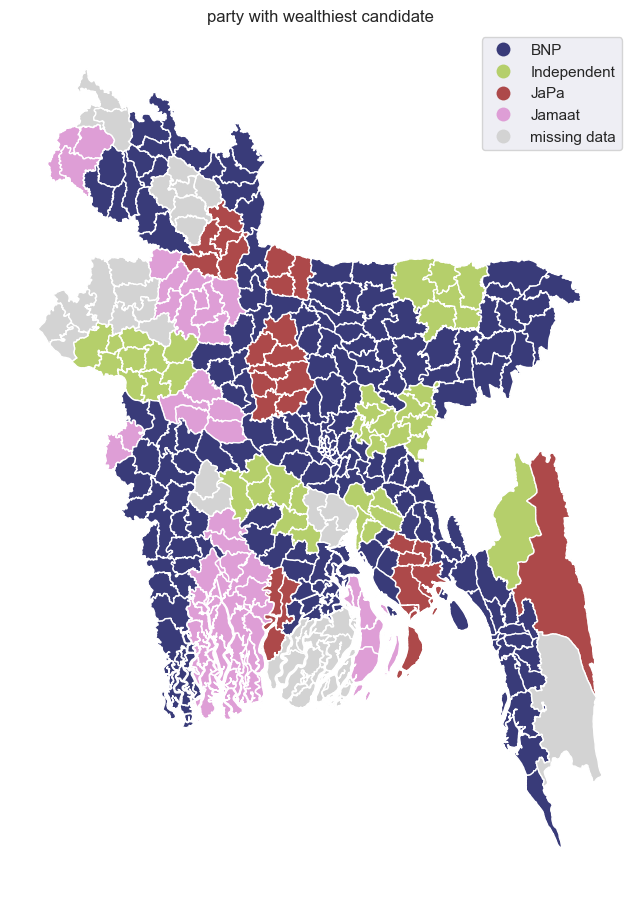

In [21]:
# plot map of party with wealthiest candidate in each district
mappwmax = pd.merge(bdmap, dfpwmax, how='left', on='district')

fig, ax = plt.subplots(figsize=(8, 14))

mappwmax.plot(
    column='party', 
    categorical=True,
    legend=True,
    cmap='tab20b', 
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "missing data",
    }
)

ax.set_axis_off()
ax.title.set_text("party with wealthiest candidate")
fig.savefig('fig/affidavit_wealth_top_by_district',bbox_inches='tight')